In [111]:

import pandas as pd
import pymysql
# from sql_info import USER, PASSWORD, DB_NAME 
from mysql_info import USER, PASSWORD, DB_NAME # 별도의 파일로 MySQL 접속 관리
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from matplotlib.ticker import MaxNLocator
import seaborn as sns 

# sns.set_theme('darkgrid') # 글씨 깨진다 - 바꿀 때마다 폰트 설정해주면 ㅇㅋ
sns.set(font_scale = 1.5)
sns.set_palette("pastel")

# 한글 깨지는 현상 수정
f_path = "C:/windows/Fonts/malgun.ttf"
font_manager.FontProperties(fname=f_path).get_name()
rc('font', family='Malgun Gothic')


import warnings
warnings.filterwarnings(action = 'ignore')

pd.set_option('display.max_colwidth', 100) # 데이터의 길이가 길면 ...되는 부분을 없앰


In [90]:
# 22년 1월 1일부터 데이터가 수집되었음 - 조회시 참고
def ReadPreviousWeeks(weeks = 4, read_all = False):

    db = pymysql.connect(host='localhost', user = USER, passwd = PASSWORD, db = DB_NAME, charset = 'utf8')

    # 일단 메모리 측면에서 생각해보면 당연히 쿼리를 날려서 일부 데이터만 메모리에 올리는 쪽이 훨씬 효율적일 것

    end_date = datetime.today().date()
    
    if read_all:
        start_date = '2022-01-01'
    else:
        start_date = end_date - timedelta(weeks = weeks)
    
    query1 = f"SELECT * FROM reports WHERE date >= '{start_date}' and date <= '{end_date}' ORDER BY date DESC"

#     query1 = (f"SELECT r.company as company, r.date as date, r.written_by as written_by, \
#             c.code as company_code, c.category as category, r.reports_idx as reports_idx\
#             FROM reports r \
#             JOIN companies c \
#             ON r.company = c.company \
#             WHERE date >= '{start_date}' and date <= '{end_date}'")

    query2 = (f"SELECT * \
                FROM companies")

    reports_df = pd.read_sql_query(query1, db)
    companies_df = pd.read_sql_query(query2, db)
    # reports_df.drop_index()

    db.close()

    return reports_df, companies_df, start_date, end_date


# 가공하는 부분을 따로 떼어냄
def processing_df(reports_df, companies_df, URL = False):
    
    # date는 object로 불러오므로 날짜 데이터로 변환
    reports_df['date'] = pd.to_datetime(reports_df['date'])
    
    # df에 레포트 보고서 링크와 기업 정보 링크를 넣고 싶다면 추가
    if URL:
        
        HK_URL =  "http://hkconsensus.hankyung.com/apps.analysis/analysis.downpdf?report_idx="
        reports_df['reports_link'] = HK_URL + reports_df['reports_idx']
        
        # companies_df 항목 수정 : 기업 코드 제거 & 해당 종목 네이버증권 URL 첨부

        NAVER_COMPANY_INFO_URL = "https://finance.naver.com/item/main.naver?code="
        companies_df['companies_info'] = NAVER_COMPANY_INFO_URL + companies_df['code']
        
    
    # 필요없는 column들 제거 - 기업 코드는 혹시 몰라 살려두지만 레포트 인덱스는 보고서 조회 외에는 필요 없어보여 제거
    reports_df.drop('reports_idx', axis = 1, inplace = True)
    # companies_df.drop('code', axis = 1, inplace = True)
    
    # 인덱스 초기화
    reports_df.reset_index()



# 필요하다면 merge를 해준다
def merge_df(reports_df, companies_df):
    total_df = pd.merge(reports_df, companies_df, on = 'company')
    total_df['YearMonth'] = total_df['date'].dt.strftime('%Y-%m')
    return total_df
    

In [122]:
reports_df, companies_df, start_date, end_date = ReadPreviousWeeks(weeks = 20,
                                                                read_all = True)
processing_df(reports_df, companies_df, URL = True)

total_df = merge_df(reports_df, companies_df) # 아래 코드 진행은 merge_df로 진행함
# total_df.head(10)

In [123]:
# 폰트 정리
suptitle_dict = {
    'color' : 'darkred',
    'weight' : 'bold',
    'size' : 20,
    # 'fontsize' : 20
}

In [124]:
category_lst = total_df['category'].value_counts()


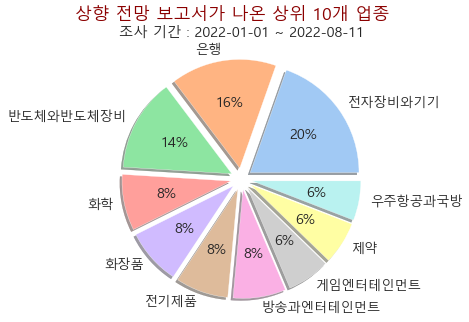

In [125]:
# 시각화
# 1. 가장 많은 상향 보고서가 나온 산업 num개를 보여줌(기본 10개)
def ShowCategory(num = 10):
        
        sns.set(font_scale = 1.2) # n이 커지면 폰트 크기는 작아져야 함
        f_path = "C:/windows/Fonts/malgun.ttf"
        font_manager.FontProperties(fname=f_path).get_name()
        rc('font', family='Malgun Gothic')
        
        
        colors = sns.color_palette('pastel')

        fig = plt.figure(figsize = (10, 5), facecolor = 'white')
        plt.pie(category_lst.values[0:num], 
                labels = category_lst.index[0:num],
                colors = colors,
                autopct = "%.0f%%", # 부채꼴 안에 표시되는 숫자의 형식
                explode = [.1] * num,
                shadow = True,
                wedgeprops = {'linewidth' : 0.3}
                )
         
        fig.suptitle(f'상향 전망 보고서가 나온 상위 {num}개 업종', fontdict = suptitle_dict)
        plt.title(f"조사 기간 : {start_date} ~ {end_date}")
        # fig.suptitle(f'Top {num} Categories For the Last {WEEKS} Weeks', fontdict = suptitle_dict)
        
        plt.show()

ShowCategory()

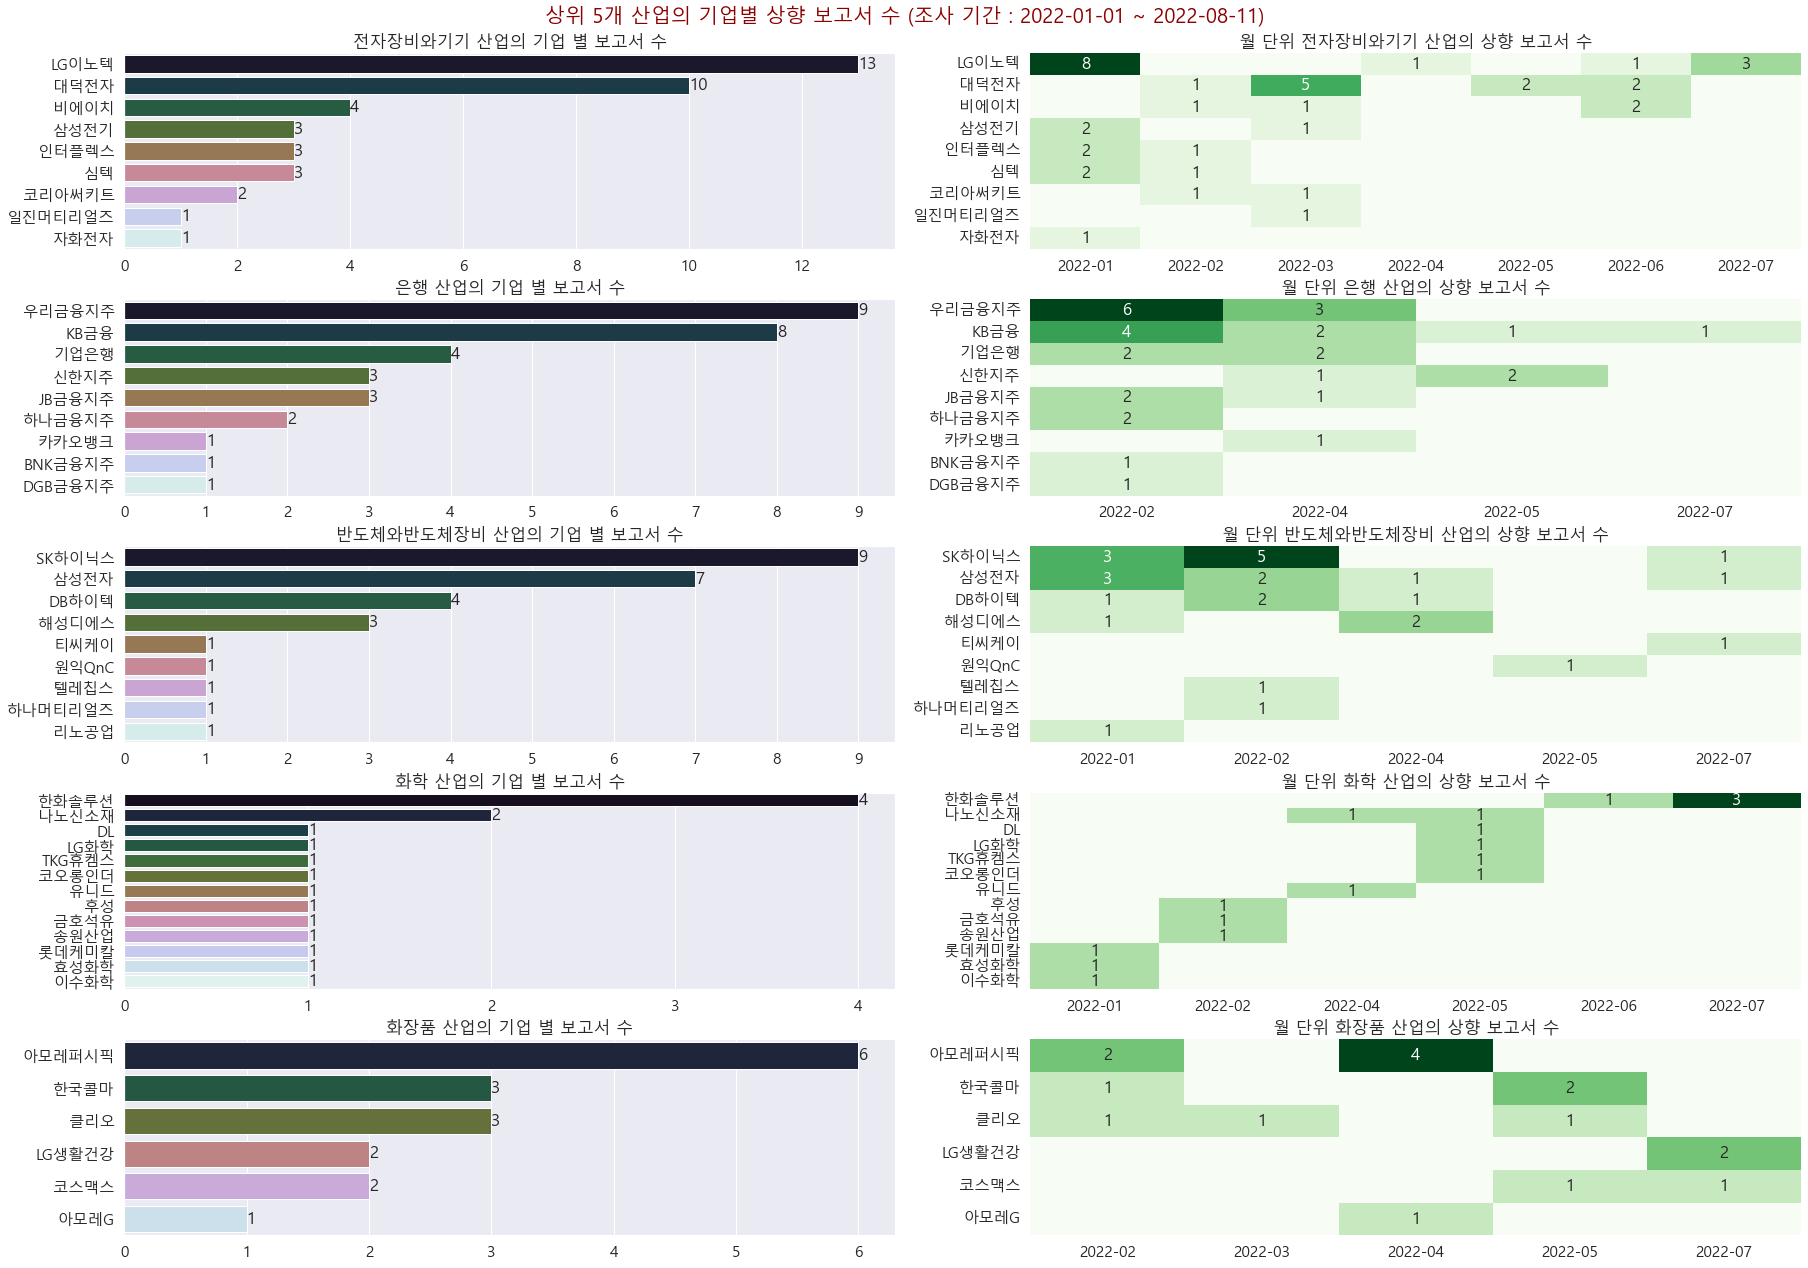

In [145]:
# 4. 두 그래프 동시에 띄우기 (각각의 코드는 삭제)

# def ShowGraphs(n): # n개의 그래프를 보여준다
n = 5

sns.set(font_scale = 1 + 0.08*n) # n이 커지면 폰트 크기는 작아져야 함
f_path = "C:/windows/Fonts/malgun.ttf"
font_manager.FontProperties(fname=f_path).get_name()
rc('font', family='Malgun Gothic')

fig, ax = plt.subplots(n, 2, figsize = (5*n, 3.5*n), constrained_layout = True)


fig.suptitle(f'상위 {n}개 산업의 기업별 상향 보고서 수 (조사 기간 : {start_date} ~ {end_date})', fontdict = suptitle_dict)
for i in range(n):
    # 왼쪽 : 막대 그래프
    selected_df = total_df[total_df['category'] == category_lst.index[i]][['company', 'YearMonth']]
    
    cp_lst = selected_df['company'].value_counts()
    
    ax[i][0].title.set_text(f"{category_lst.index[i]} 산업의 기업 별 보고서 수")
    g1 = sns.barplot(x = cp_lst, y = cp_lst.index, ax = ax[i][0], palette = "cubehelix")
    g1.set(title = f"{category_lst.index[i]} 산업의 기업 별 보고서 수")
    g1.set(xlabel = None)
    ax[i][0].bar_label(ax[i][0].containers[0]) # 갯수 표시
    ax[i][0].xaxis.set_major_locator(MaxNLocator(integer = True))
    
    # 오른쪽 : 히트맵
    order = cp_lst.index
    heatmap_df = selected_df.groupby(['company', 'YearMonth']).size() # Series
    heatmap_df = heatmap_df.reset_index() # 오; to_frame 없이 reset_index만 해줘도 잘 나오는듯
    heatmap_df = heatmap_df.rename(columns = {0 : 'counts'})
    heatmap_df = heatmap_df.pivot('company', 'YearMonth', 'counts')
    heatmap_df = heatmap_df.fillna(0)

    heatmap_df = heatmap_df.loc[order] # 순서 정렬
    # ax[i][1].title.set_text(f"월 단위 {category_lst.index[i]} 산업의 상향 보고서 수")
    # ax[i][1].xaxis
    
    g2 = sns.heatmap(heatmap_df, cmap = 'Greens', annot = True, ax = ax[i][1], cbar=False, 
                     yticklabels = True) # 모든 데이터를 보여주기 위해 넣음
    g2.set(title = f"월 단위 {category_lst.index[i]} 산업의 상향 보고서 수")
    g2.set(xlabel = None)
    
    # 0 데이터 제외하기
    for t in ax[i][1].texts:
        if int(t.get_text())>=1:
            t.set_text(t.get_text())
        else:
            t.set_text("")
    

In [138]:
# 오른쪽에 똑같이 표시되지 않는 현상 개선
heatmap_df = total_df[total_df['category'] == category_lst.index[2]][['company', 'YearMonth']]

cp_lst =heatmap_df['company'].value_counts()
print(cp_lst)

SK하이닉스     9
삼성전자       7
DB하이텍      4
해성디에스      3
티씨케이       1
원익QnC      1
텔레칩스       1
하나머티리얼즈    1
리노공업       1
Name: company, dtype: int64


In [139]:
heatmap_df = total_df[total_df['category'] == category_lst.index[2]][['company', 'YearMonth']]
heatmap_df.head()
heatmap_df = heatmap_df.groupby(['company', 'YearMonth']).size() # Series
heatmap_df = heatmap_df.reset_index() # 오; to_frame 없이 reset_index만 해줘도 잘 나오는듯
heatmap_df = heatmap_df.rename(columns = {0 : 'counts'})
heatmap_df = heatmap_df.pivot('company', 'YearMonth', 'counts')

heatmap_df = heatmap_df.fillna(0)

heatmap_df = heatmap_df.loc[order] # 순서 정렬
print(heatmap_df)


YearMonth  2022-01  2022-02  2022-04  2022-05  2022-07
SK하이닉스         3.0      5.0      0.0      0.0      1.0
삼성전자           3.0      2.0      1.0      0.0      1.0
DB하이텍          1.0      2.0      1.0      0.0      0.0
해성디에스          1.0      0.0      2.0      0.0      0.0
티씨케이           0.0      0.0      0.0      0.0      1.0
원익QnC          0.0      0.0      0.0      1.0      0.0
텔레칩스           0.0      1.0      0.0      0.0      0.0
하나머티리얼즈        0.0      1.0      0.0      0.0      0.0
리노공업           1.0      0.0      0.0      0.0      0.0


In [140]:
print(cp_lst.index)
print(heatmap_df.index)

Index(['SK하이닉스', '삼성전자', 'DB하이텍', '해성디에스', '티씨케이', '원익QnC', '텔레칩스', '하나머티리얼즈',
       '리노공업'],
      dtype='object')
Index(['SK하이닉스', '삼성전자', 'DB하이텍', '해성디에스', '티씨케이', '원익QnC', '텔레칩스', '하나머티리얼즈',
       '리노공업'],
      dtype='object')
